# 0. Setup Paths

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [6]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [ ]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip install Pillow

In [ ]:
!pip install pyyaml

In [ ]:
!pip list

In [ ]:
!pip install tensorflow --upgrade

In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2

In [ ]:
import object_detection

In [ ]:
!pip list

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Create Label Map

In [5]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Update Config For Transfer Learning

In [6]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [7]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 4. Train the model

In [79]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [80]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [81]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=10000


# 5. Load Train Model From Checkpoint

In [8]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [9]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 6. Detect from an Image

In [12]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [16]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars425.png')

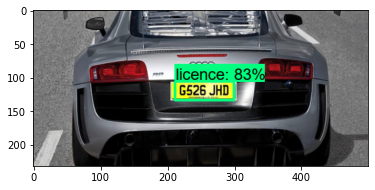

In [17]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# Apply OCR to detection 

In [18]:
!pip install easyocr 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.7.0 requires google-api-python-client>=1.6.7, which is not installed.
tf-models-official 2.7.0 requires kaggle>=1.3.9, which is not installed.
tf-models-official 2.7.0 requires oauth2client, which is not installed.
tf-models-official 2.7.0 requires psutil>=5.4.3, which is not installed.
tf-models-official 2.7.0 requires py-cpuinfo>=3.3.0, which is not installed.
tf-models-official 2.7.0 requires pycocotools, which is not installed.
tf-models-official 2.7.0 requires sacrebleu, which is not installed.
tf-models-official 2.7.0 requires sentencepiece, which is not installed.
tf-models-official 2.7.0 requires seqeval, which is not installed.
tf-models-official 2.7.0 requires tensorflow-datasets, which is not installed.
tf-models-official 2.7.0 requires tensorflow-hub>=0.6.0, which is not installed.


  Using cached opencv_python_headless-4.5.5.62-cp36-abi3-win_amd64.whl (35.3 MB)


In [19]:
!pip install torch torchvision torchaudio

You should consider upgrading via the 'd:\anpr\anprsys\scripts\python.exe -m pip install --upgrade pip' command.


In [21]:
import easyocr

In [22]:
detection_threshold=0.7

In [23]:
image=image_np_with_detections
scores=list(filter(lambda x: x > detection_threshold, detections['detection_scores']))
boxes=detections['detection_boxes'][:len(scores)]
classes=detections['detection_classes'][:len(scores)]

In [24]:
width=image.shape[1]
height=image.shape[0]

Using CPU. Note: This module is much faster with a GPU.


[([[4, 2], [86, 2], [86, 26], [4, 26]], '6526 JHD', 0.9352129860527575)]


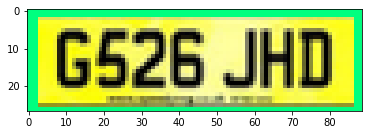

In [25]:
#Apply ROI filtering and OCR:                    , ROI:Region Of Interest

for idx, box in enumerate(boxes):
    roi=box*[height, width, height, width]
    region=image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader=easyocr.Reader(['en'], gpu=False)
    ocr_result=reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
               # loading images from openCv & visualising them with matplotlib , we need to convert them from BGR->RGB

# OCR Filtering

In [27]:
region_threshold=0.6

In [28]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size=region.shape[0]*region.shape[1]
    
    plate=[]
    
    for result in ocr_result:
        length=np.sum(np.subtract(result[0][1],result[0][0]))
        height=np.sum(np.subtract(result[0][2],result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
        
        print(length, width)
        
    return plate

In [29]:
filter_text(region, ocr_result, region_threshold)

82 500


['6526 JHD']

# Bring it together

In [31]:
def ocr_it(images, detections, detection_threshold, region_threshold):

    scores=list(filter(lambda x: x > detection_threshold, detections['detection_scores']))
    boxes=detections['detection_boxes'][:len(scores)]
    classes=detections['detection_classes'][:len(scores)]

    width=image.shape[1]
    height=image.shape[0]
    
    #Apply ROI filtering and OCR:                    , ROI:Region Of Interest

    for idx, box in enumerate(boxes):
        roi=box*[height, width, height, width]
        region=image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader=easyocr.Reader(['en'], gpu=False)
        ocr_result=reader.readtext(region)
        
        text=filter_text(region, ocr_result, region_threshold)
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        
        return text, region

Using CPU. Note: This module is much faster with a GPU.


82 500


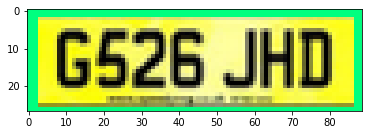

In [32]:
text, region=ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

In [33]:
text

['6526 JHD']

In [34]:
region

array([[[127, 255,   0],
        [127, 255,   0],
        [127, 255,   0],
        ...,
        [127, 255,   0],
        [127, 255,   0],
        [127, 255,   0]],

       [[127, 255,   0],
        [127, 255,   0],
        [127, 255,   0],
        ...,
        [127, 255,   0],
        [127, 255,   0],
        [127, 255,   0]],

       [[127, 255,   0],
        [127, 255,   0],
        [127, 255,   0],
        ...,
        [100, 227, 225],
        [127, 255,   0],
        [127, 255,   0]],

       ...,

       [[127, 255,   0],
        [127, 255,   0],
        [127, 255,   0],
        ...,
        [ 51, 255, 255],
        [127, 255,   0],
        [127, 255,   0]],

       [[127, 255,   0],
        [127, 255,   0],
        [127, 255,   0],
        ...,
        [ 46, 151, 148],
        [127, 255,   0],
        [127, 255,   0]],

       [[127, 255,   0],
        [127, 255,   0],
        [127, 255,   0],
        ...,
        [127, 255,   0],
        [127, 255,   0],
        [127, 255,   0]]

# Save Results

In [35]:
import csv
import uuid # Unique Uniform IDentifier

In [36]:
'{}.jpg'.format(uuid.uuid1())

'ee378b01-845a-11ec-800d-74867a61dab0.jpg'

In [37]:
def save_results (text, region, csv_filename, folder_path):
    img_name='{}.jpg'.format(uuid.uuid1())
    
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer=csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name,text])
    

In [38]:
save_results (text, region, 'detection_Results.csv', 'Detection_Images')

# 8. Real Time Detections from your Webcam

Using CPU. Note: This module is much faster with a GPU.


83 640


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.


78 640
81 640


Using CPU. Note: This module is much faster with a GPU.


39 640


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.


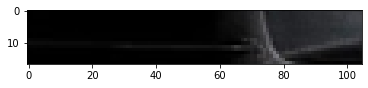

In [39]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try:
        text, region=ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
        save_results (text, region, 'Real_Time_Detection.csv', 'Detection_Images')
    except:
        pass
    
    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break